In [1]:
import pandas as pd
import nltk
import json  
import sys  

import seaborn as sns  
import matplotlib.pyplot as plt  

from nltk.stem.snowball import EnglishStemmer
import plotly.express as px  

# nltk.download('punkt')
# nltk.download('stopwords')



## Recupérer et explorer les données

Je commence par lire mon fichier d'entrée

In [2]:
df = pd.read_csv("./../input/flipkart_com-ecommerce_sample_1050.csv")

In [3]:
print("Shape is", df.shape)
df.head()

Shape is (1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Je n'ai pas besoin de toute les colonnes, je conserve que ce qui m'interesse

In [4]:
df = df[["uniq_id","product_name","product_category_tree", "description"]]
df.head()

,uniq_id,product_name,product_category_tree,description
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uniq_id                1050 non-null   object
 1   product_name           1050 non-null   object
 2   product_category_tree  1050 non-null   object
 3   description            1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


In [6]:
df.nunique()

uniq_id                  1050
product_name             1050
product_category_tree     642
description              1050
dtype: int64

In [7]:
df.isna().sum()

uniq_id                  0
product_name             0
product_category_tree    0
description              0
dtype: int64

Je mets les categories sous forme de colonne hierachique

In [8]:
# Define a function to split and create the category columns dynamically  
def create_category_columns(row):
    json_categories = json.loads(row["product_category_tree"])
    if(len(json_categories) > 1):
        print("Categories array > 1, update the script to cover that.")
        sys.exit(1)  

    split_categories = json_categories[0].split(">>")
    
    for i, category in enumerate(split_categories):
        column_name = f"category_lvl_{i + 1}"  
        row[column_name] = category.strip().lower()
    return row

# Apply the funcion to all rows
df = df.assign(**df.apply(lambda row: create_category_columns(row), axis=1))  


In [9]:
df.head()

,uniq_id,product_name,product_category_tree,description,category_lvl_1,category_lvl_2,category_lvl_3,category_lvl_4,category_lvl_5,category_lvl_6,category_lvl_7
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,home furnishing,curtains & accessories,curtains,elegance polyester multicolor abstract eyelet ...,NaN,NaN,NaN
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,baby care,baby bath & skin,baby bath towels,sathiyas baby bath towels,"sathiyas cotton bath towel (3 bath towel, red,...",NaN,NaN
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,baby care,baby bath & skin,baby bath towels,eurospa baby bath towels,eurospa cotton terry face towel set (20 piece ...,NaN,NaN
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,home furnishing,bed linen,bedsheets,santosh royal fashion bedsheets,santosh royal fashion cotton printed king size...,NaN,NaN
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,home furnishing,bed linen,bedsheets,jaipur print bedsheets,jaipur print cotton floral king sized double b...,NaN,NaN


In [10]:
df.isna().sum()

uniq_id                    0
product_name               0
product_category_tree      0
description                0
category_lvl_1             0
category_lvl_2             0
category_lvl_3             3
category_lvl_4           371
category_lvl_5           645
category_lvl_6           923
category_lvl_7           993
dtype: int64

In [11]:
df["category_lvl_3"].fillna("undefined",inplace=True)
df["category_lvl_4"].fillna("undefined",inplace=True)
df["category_lvl_5"].fillna("undefined",inplace=True)
df["category_lvl_6"].fillna("undefined",inplace=True)
df["category_lvl_7"].fillna("undefined",inplace=True)
df.isna().sum()


uniq_id                  0
product_name             0
product_category_tree    0
description              0
category_lvl_1           0
category_lvl_2           0
category_lvl_3           0
category_lvl_4           0
category_lvl_5           0
category_lvl_6           0
category_lvl_7           0
dtype: int64

Je regarde la distribution de mes valeurs sur la première catégorie

In [12]:
df['category_lvl_1'].value_counts()

home furnishing               150
baby care                     150
watches                       150
home decor & festive needs    150
kitchen & dining              150
beauty and personal care      150
computers                     150
Name: category_lvl_1, dtype: int64

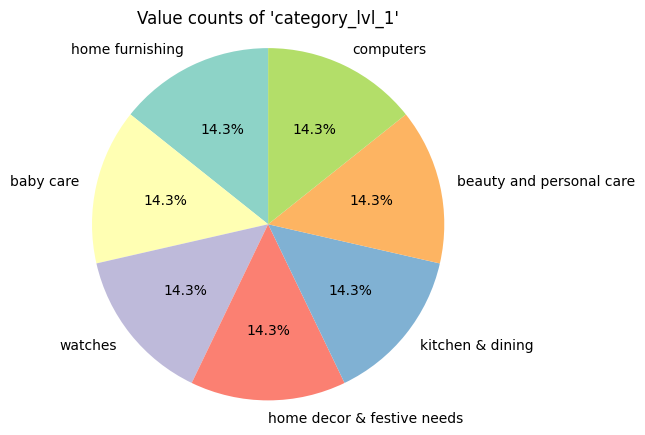

In [13]:
# Assuming 'df' is your DataFrame  
category_counts = df['category_lvl_1'].value_counts()  
  
# Set color palette from seaborn  
colors = sns.color_palette('Set3')  
  
# Create pie chart  
plt.figure(figsize=(5, 5))  
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)  
plt.axis('equal')  
plt.title("Value counts of 'category_lvl_1'")  
  
# Show the chart  
plt.show()  

La distribution est similaire pour chaque produits, j'affiche la 2e catégorie via le graphique sunburst

In [14]:
fig = px.sunburst(df, path=['category_lvl_1', 'category_lvl_2'])

fig.update_layout(  
    margin=dict(t=0, l=0, r=0, b=0),  
    width=500,  
    height=500,  
    title="Zoomable Sunburst Chart"  
)  

fig.show()

Je visualize avec Treemap pour observer la différence de rendu avec sunburst pour utiliser lors de la présentation

In [15]:
fig = px.treemap(df, path=['category_lvl_1', 'category_lvl_2', 'category_lvl_3'])  
  
fig.update_layout(  
    margin=dict(t=0, l=0, r=0, b=0),  
    width=800,  
    height=600,  
    title="Treemap Chart"  
)  
  
fig.show()

Je suis ok au niveau de la visualisation, ce qui m'interesse sera de classifier uniquement la catégorie lvl 1.  
Je vais donc mettre à jour mon dataframe

In [16]:
df = df[["uniq_id", "product_name", "description", "category_lvl_1"]]
df.head()

,uniq_id,product_name,description,category_lvl_1
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,baby care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,baby care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,home furnishing


J'effectue maintenant un one-hot encoding sur mes categories

In [17]:
df = df.rename(columns={'category_lvl_1': 'cat'})
original_df = df.copy()

df = pd.get_dummies(df, columns=["cat"])
df["cat"] = original_df["cat"]

In [18]:
df.head()

,uniq_id,product_name,description,cat_baby care,cat_beauty and personal care,cat_computers,cat_home decor & festive needs,cat_home furnishing,cat_kitchen & dining,cat_watches,cat
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,0,0,0,0,1,0,0,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,1,0,0,0,0,0,0,baby care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,1,0,0,0,0,0,0,baby care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,0,0,0,0,1,0,0,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,0,0,0,0,1,0,0,home furnishing


Je vérifie si j'ai des doublons dans la description

In [19]:
idx = df.duplicated(subset="description", keep="first")
df.loc[idx,:].sort_values("description")

,uniq_id,product_name,description,cat_baby care,cat_beauty and personal care,cat_computers,cat_home decor & festive needs,cat_home furnishing,cat_kitchen & dining,cat_watches,cat


## Nettoyer la description

Je vais maintenant nettoyer la colonne description, ce qui consiste à analyser le nombre original de token (mots) et de les réduire au maximum tout en conservant la pertinence des mots. C'est à dire retirer les mots unique, retirer les mots qui ne sont pas anglais, ...

En nettoyant cette colonne, je vais pouvoir réduire le bruit et étudier au mieux la faisabilité de classification.

Je commence d'abord par créer mon corpus, le document qui va contenir toutes les description de tous les produits.

In [20]:
# HELPERS

import os, sys, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize

from nltk.corpus import words, stopwords
from nltk.tokenize import RegexpTokenizer

from wordcloud import WordCloud
from PIL import Image
from collections import Counter  

from pandarallel import pandarallel


# nltk.download("omw-1.4")
# nltk.download("wordnet")
# nltk.download("stopwords")
# nltk.download("words")

max_workers = os.cpu_count()  
print("Maximum number of workers:", max_workers)  

pandarallel.initialize(progress_bar=True, nb_workers=max_workers)

sns.set()

# Display the number of tokens and unique
def display_token_info(tokens):
    print(f"nb tokens {len(tokens)}, nb token uniques {len(set(tokens))}")
    print(tokens[:30])
    
english_stop_words = set(stopwords.words("english"))


def process_text_step_1(doc):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    
    return:
    -------------------
    
    a list of tokens
    """
    
    # Reduce to lowercase
    doc = doc.lower().strip()
    
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    
    # Remove stop words
    # clean_tokens_list = [w for w in raw_tokens_list if w not in english_stop_words]
    
    return raw_tokens_list

def process_text_step_2(doc, stopwords):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_1(doc)
    
    # Remove stop words
    processed_tokens = [w for w in processed_tokens if w not in stopwords]
    
    return processed_tokens

def process_text_step_3(doc, stopwords):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_2(doc, stopwords)
    
    processed_tokens = [w for w in processed_tokens if w.isalpha()]
    
    return processed_tokens

def process_text_step_4(doc, 
                        stopwords, 
                        delete_words
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_3(doc, stopwords)
    processed_tokens = [w for w in processed_tokens if w not in delete_words]
    
    return processed_tokens

def process_text_step_5(doc, 
                        stopwords, 
                        delete_words,
                        min_word_length
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    min_word_length: int : a minimum number of characters per word to keep
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_4(doc, stopwords, delete_words)
    processed_tokens = [w for w in processed_tokens if len(w) >= min_word_length]

    return processed_tokens

def process_text_step_6(doc, 
                        stopwords, 
                        delete_words,
                        min_word_length,
                        use_lemm,
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    min_word_length: int : a minimum number of characters per word to keep
    use_lemm: bool : define if it uses lemmatizer, if false, it will defined stemmer
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_5(doc, stopwords, delete_words, min_word_length)

    if use_lemm:
         trans = WordNetLemmatizer()
         processed_tokens = [trans.lemmatize(i) for i in processed_tokens]
    else:
        trans = PorterStemmer()
        processed_tokens = [trans.stem(i) for i in processed_tokens]

    # Could improve this by reordering step, not needed for now
    # Once again, I remove all tokens >= min_word_length
    processed_tokens = [w for w in processed_tokens if len(w) >= min_word_length]
    # Once again, I remove all delete_words
    processed_tokens = [w for w in processed_tokens if w not in delete_words]

    return processed_tokens

def final_process(doc, 
                        stopwords, 
                        delete_words,
                        min_word_length,
                        use_lemm,
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    min_word_length: int : a minimum number of characters per word to keep
    use_lemm: bool : define if it uses lemmatizer, if false, it will defined stemmer
    
    return:
    -------------------
    
    a str of joined token
    """
    processed_tokens = process_text_step_6(doc, stopwords, delete_words, min_word_length, use_lemm)

    if use_lemm:
         trans = WordNetLemmatizer()
         processed_tokens = [trans.lemmatize(i) for i in processed_tokens]
    else:
        trans = PorterStemmer()
        processed_tokens = [trans.stem(i) for i in processed_tokens]

    # Could improve this by reordering step, not needed for now
    # Once again, I remove all tokens >= min_word_length
    processed_tokens = [w for w in processed_tokens if len(w) >= min_word_length]
    # Once again, I remove all delete_words
    processed_tokens = [w for w in processed_tokens if w not in delete_words]

    return " ".join(processed_tokens)

def process_text_step_7_deprecated(doc, 
                        stopwords, 
                        delete_words,
                        min_word_length,
                        use_lemm,
                        allow_words,
                        ):
    """
    required arguments:
    -------------------
    
    doc: str : the document to process
    stopwords: list : a list of stopwords to remove from the token
    delete_words: list : a list of words to remove from the token
    min_word_length: int : a minimum number of characters per word to keep
    use_lemm: bool : define if it uses lemmatizer, if false, it will defined stemmer
    include_words: list : a list of words to allow to keep
    
    return:
    -------------------
    
    a list of tokens
    """
    processed_tokens = process_text_step_6(doc, stopwords, delete_words, min_word_length, use_lemm)
    processed_tokens = [i for i in processed_tokens if i in allow_words]
    return processed_tokens


Maximum number of workers: 8
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [21]:
raw_corpus = "".join(df["description"].values)

J'observe le nombre de charactères

In [22]:
len(raw_corpus)

497512

**Première analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule

In [23]:
tokens = process_text_step_1(raw_corpus)
display_token_info(tokens)

nb tokens 81219, nb token uniques 6284
['key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'in', 'height', 'pack', 'of', '2', 'price', 'rs', '899', 'this']


J'ai donc un nombre de token initial de 81,219 token et 6,284 unique.  
Je vais tenter de réduire se nombre au maximum par itération.  

Je souhaite retirer tous les mots qui sont considérés comme stopwords en Anglais, des mots qui ne seront pas utile à définir une catégorie (le, la, les, ...)

**Deuxième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.

In [24]:
tokens = process_text_step_2(raw_corpus, english_stop_words)
display_token_info(tokens)

nb tokens 61452, nb token uniques 6165
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'height', 'pack', '2', 'price', 'rs', '899', 'curtain', 'enhances', 'look', 'interiors']


Déjà ~20k tokens retiré, c'est que le début

Maintenant je souhaite retirer toutes les valeurs qui sont des nombres, je ne pense pas que les valeurs numériques me permettent de mieux distinguer une catégorie.

**Troisième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.
- Je supprime tous les mots numériques

In [25]:
tokens = process_text_step_3(raw_corpus, english_stop_words)
display_token_info(tokens)

nb tokens 55288, nb token uniques 5074
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'rs', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high']


6k tokens de réduit donc 1k token uniques.  
Maintenant, je pense que tous les mots présent uniquement une seul fois dans le corpus ne sont pas utiles pour déterminer une catégorie, je vais donc les supprimer.

In [26]:
pd.Series(tokens).value_counts()

rs          911
products    631
free        618
delivery    567
genuine     564
           ... 
spectrum      1
hydrate       1
aveeno        1
exposed       1
mono          1
Length: 5074, dtype: int64

In [27]:
all_tokens = pd.Series(tokens).value_counts()
tokens_one_occurence = all_tokens[all_tokens==1]
tokens_one_occurence = list(tokens_one_occurence.index)

print("len",len(tokens_one_occurence))
tokens_one_occurence[:5]

len 1591


['buffet', 'valance', 'bagru', 'cmskey', 'fetch']

**Quatrième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.
- Je supprime tous les mots numériques
- Je supprime tous les mots qui sont présent qu'une seul fois


In [28]:
tokens = process_text_step_4(raw_corpus, english_stop_words, delete_words=tokens_one_occurence)
display_token_info(tokens)

nb tokens 53697, nb token uniques 3483
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'rs', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high']


~1500 tokens unique retiré. Je continue.  
Je vais observer tous les mots qui ont moins de 3 caractères, je ne suis pas sur que ces mots définissent une catégorie facilement.

Rien d'interessant a vue d'oeil.  
Je les supprime.

**Cinquième analyse:**
- Je tokenize mon document en conservant les caractères alphanumérique et en mettant chaque mot en minuscule
- Je supprime les token qui comprennent les stopwords Anglais.
- Je supprime tous les mots numériques
- Je supprime tous les mots qui sont présent qu'une seul fois
- Je supprime tous les mots qui font moins de 3 caractères


In [29]:
tokens = process_text_step_5(raw_corpus, english_stop_words, delete_words=tokens_one_occurence, min_word_length=3)
display_token_info(tokens)

nb tokens 51097, nb token uniques 3396
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high', 'quality', 'polyester']


Pas beaucoup de tokens retirés, c'est mieux que rien.  
Maintenant le plus intéressant, stemmer ou lemmatizer ?

- Stemmer: réduit les mots à leur racine (supprime les affixes) (rapide et ne tient pas en compte le contexte)
- Lemmatizer: Normalize les mots depuis un dictionnaire (lent et tient en compte le sens des mots)

Ici, je souhaite classifier une catégorie, je ne pense pas que le sens des mots soit important comparé à une analyse de positivité d'un text.  
Je pense utiliser celui qui me supprimera le plus de token. Je pourrais aussi retenter mon approche plus bas avec l'autre méthode.

In [30]:
tokens = process_text_step_6(raw_corpus, 
                             english_stop_words, 
                             delete_words=tokens_one_occurence, 
                             min_word_length=3,
                             use_lemm=True)
display_token_info(tokens)

nb tokens 50695, nb token uniques 3092
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester']


In [31]:
tokens = process_text_step_6(raw_corpus, 
                             english_stop_words, 
                             delete_words=tokens_one_occurence, 
                             min_word_length=3,
                             use_lemm=False)
display_token_info(tokens)

nb tokens 50407, nb token uniques 2727
['key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhanc', 'look', 'interior', 'curtain', 'made', 'high', 'qualiti', 'polyest']


Plus rapide et moins de token par stemmer, je vais donc utiliser cette méthode par la suite.  
Ça commence à être pas trop mal. 

Je vais maintenant tester de retirer tous les mots qui ne sont pas dans la langue anglaise.

In [32]:
eng_words = [i.lower() for i in words.words()]
len(set(eng_words))

234377

In [33]:
tokens = process_text_step_7_deprecated(raw_corpus, 
                             english_stop_words, 
                             delete_words=tokens_one_occurence, 
                             min_word_length=3,
                             use_lemm=False,
                             allow_words=eng_words)
display_token_info(tokens)

nb tokens 33649, nb token uniques 1490
['key', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'look', 'interior', 'curtain', 'made', 'high', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room']


Je suis pas fan, j'ai peur de retirer trop de mots. Je perds "featur", même si je modifie le step 7 pour ne pas faire de stemmer, je perds également le mot "feature".  
Je n'ai pas confiance en cette méthode, je ne l'utiliserai pas.

C'est déjà pas mal, je vais observer les mots les plus courant pour chaque catégorie puis vérifier si il y a des doublons entre toute les catégories et supprimer ce que je trouve inutile.

In [34]:
df.columns

Index(['uniq_id', 'product_name', 'description', 'cat_baby care',
       'cat_beauty and personal care', 'cat_computers',
       'cat_home decor & festive needs', 'cat_home furnishing',
       'cat_kitchen & dining', 'cat_watches', 'cat'],
      dtype='object')

cat_baby care has 72541 characters for 8186 words


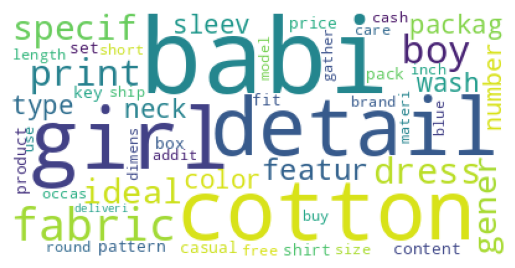

cat_beauty and personal care has 56618 characters for 5847 words


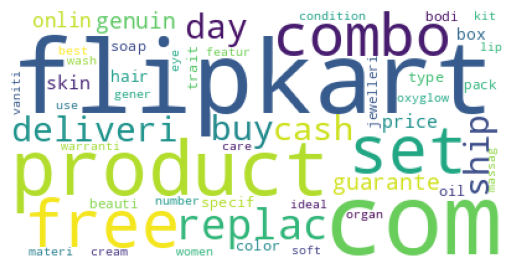

cat_computers has 83329 characters for 8331 words


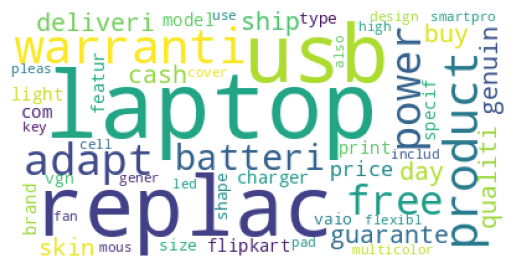

cat_home decor & festive needs has 84704 characters for 8194 words


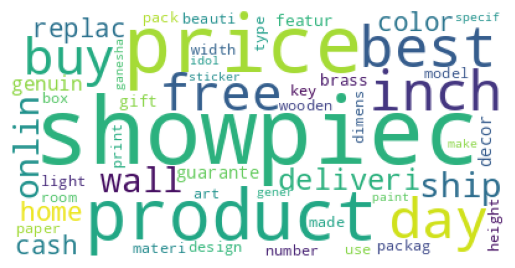

cat_home furnishing has 57118 characters for 5924 words


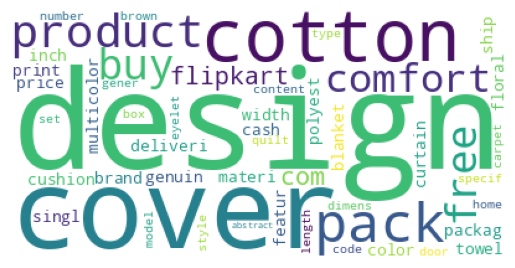

cat_kitchen & dining has 95162 characters for 9289 words


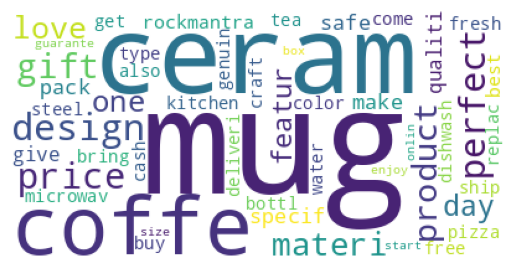

cat_watches has 49083 characters for 5059 words


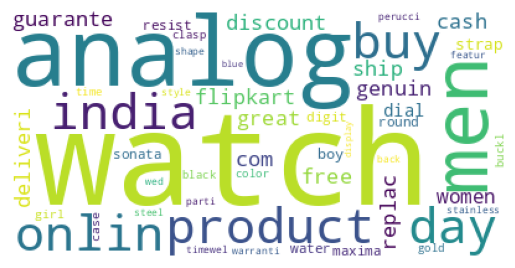

In [35]:
categories = ["cat_baby care","cat_beauty and personal care","cat_computers","cat_home decor & festive needs","cat_home furnishing","cat_kitchen & dining","cat_watches"]

tokens_per_cat={}
for idx, cat in enumerate(categories):
    df_cat = df[df[cat] == 1]
    cat_corpus = " ".join(df_cat["description"])
    
    tokens_per_cat[cat] = process_text_step_6(cat_corpus, 
                             english_stop_words, 
                             delete_words=tokens_one_occurence, 
                             min_word_length=3,
                             use_lemm=False)
    
    print(f"{cat} has {len(cat_corpus)} characters for {len(tokens_per_cat[cat])} words")
    word_frequencies = Counter(tokens_per_cat[cat])  

    wordcloud = WordCloud(background_color="white",
                      stopwords=[],
                      max_words=50).generate_from_frequencies(frequencies=word_frequencies)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    

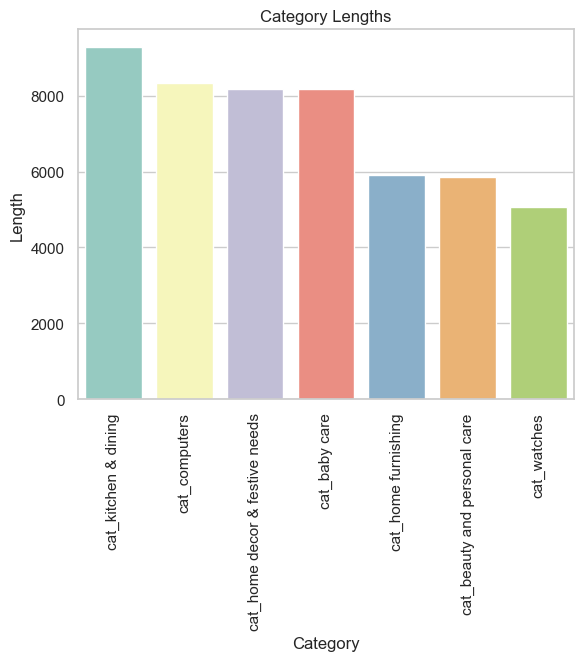

In [36]:
category_keys = list(tokens_per_cat.keys())  
  
lengths = [len(tokens_per_cat[key]) for key in category_keys]  
df_cat = pd.DataFrame({"Category": category_keys, "Length": lengths})  
df_cat = df_cat.sort_values(by="Length", ascending=False)  
  
color_palette = sns.color_palette("Set3")  
sns.set(style="whitegrid")  
sns.barplot(x="Category", y="Length", data=df_cat, palette=color_palette)  
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary  
plt.xlabel("Category")  
plt.ylabel("Length")  
plt.title("Category Lengths")  
plt.show()  

In [37]:
categories = list(tokens_per_cat.keys())  
duplicated_values = []  
  
for value in pd.Series(tokens_per_cat[categories[0]]).value_counts().index:  
    if all(value in pd.Series(tokens_per_cat[cat]).values for cat in categories[1:]):  
        duplicated_values.append(value)
  
print(len(duplicated_values))  
print(duplicated_values)

79
['specif', 'ideal', 'gener', 'featur', 'packag', 'type', 'color', 'number', 'content', 'pack', 'price', 'box', 'product', 'set', 'key', 'blue', 'brand', 'free', 'size', 'use', 'dimens', 'buy', 'materi', 'cash', 'genuin', 'made', 'ship', 'deliveri', 'style', 'flipkart', 'comfort', 'day', 'design', 'cover', 'pink', 'width', 'suitabl', 'one', 'green', 'water', 'look', 'qualiti', 'replac', 'beauti', 'weight', 'red', 'multi', 'may', 'black', 'make', 'colour', 'white', 'height', 'light', 'like', 'vari', 'back', 'long', 'get', 'bodi', 'high', 'india', 'add', 'great', 'finish', 'durabl', 'shape', 'manufactur', 'place', 'sure', 'world', 'well', 'new', 'touch', 'need', 'wide', 'rang', 'come', 'life']


J'ai 79 mots en doublons dans toutes les catégories. Ça me rajoutera du bruit, je préfère les retirer.  
Pour rappel, le résultat précédent que je conserve est: `nb tokens 51097, nb token uniques 3123`

In [66]:
words_deleted_manually = []
# words_deleted_manually = ["com","guarante","best","onlin","warranti","print"]
new_delete_words = list(set(tokens_one_occurence + duplicated_values + words_deleted_manually))
tokens = process_text_step_6(raw_corpus, 
                             english_stop_words, 
                             delete_words=new_delete_words, 
                             min_word_length=3,
                             use_lemm=True)
display_token_info(tokens)

nb tokens 39942, nb token uniques 3030
['feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'curtain', 'enhances', 'interior', 'curtain', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'stitch', 'metal', 'ring', 'room']


Beaucoup de mots retirés mais je suis confiant que c'est utile.

In [67]:
tokens_per_cat[cat]

['time',
 'analog',
 'watch',
 'boy',
 'time',
 'analog',
 'watch',
 'boy',
 'discount',
 'camerii',
 'eleg',
 'analog',
 'watch',
 'men',
 'boy',
 'camerii',
 'eleg',
 'analog',
 'watch',
 'men',
 'boy',
 'discount',
 'star',
 'analog',
 'watch',
 'boy',
 'whether',
 'way',
 'work',
 'abroad',
 'famili',
 'lifestyl',
 'accessori',
 'watch',
 'wallet',
 'belt',
 'help',
 'sophist',
 'class',
 'otherwis',
 'mundan',
 'regular',
 'daili',
 'wear',
 'suav',
 'leather',
 'belt',
 'intric',
 'timepiec',
 'separ',
 'rest',
 'whether',
 'way',
 'work',
 'abroad',
 'famili',
 'lifestyl',
 'accessori',
 'watch',
 'wallet',
 'belt',
 'help',
 'sophist',
 'class',
 'otherwis',
 'mundan',
 'regular',
 'daili',
 'wear',
 'suav',
 'leather',
 'belt',
 'intric',
 'timepiec',
 'separ',
 'rest',
 'alfajr',
 'youth',
 'digit',
 'watch',
 'men',
 'boy',
 'alfajr',
 'youth',
 'digit',
 'watch',
 'men',
 'boy',
 'azan',
 'time',
 'around',
 'prayer',
 'qibla',
 'direct',
 'daili',
 'discount',
 'tag',
 'he

cat_baby care has 72541 characters for 5948 words


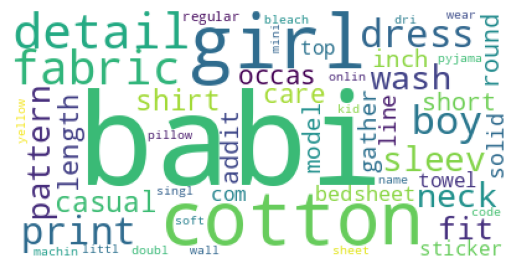

cat_beauty and personal care has 56456 characters for 3718 words


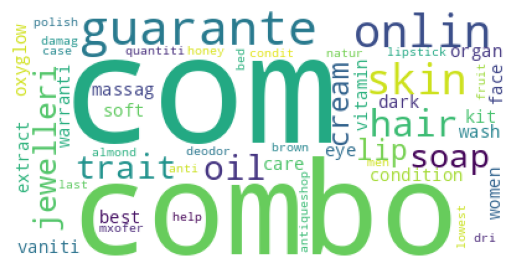

cat_computers has 82613 characters for 5834 words


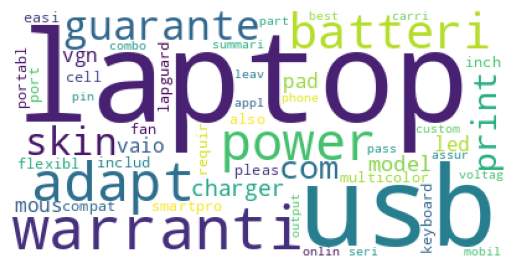

cat_home decor & festive needs has 84704 characters for 5711 words


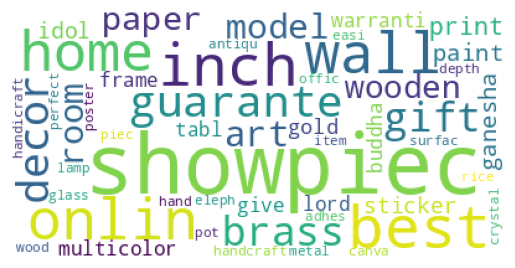

cat_home furnishing has 57118 characters for 3558 words


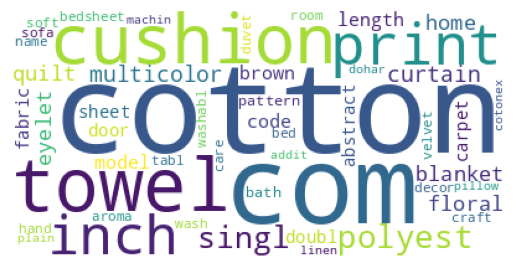

cat_kitchen & dining has 95162 characters for 6578 words


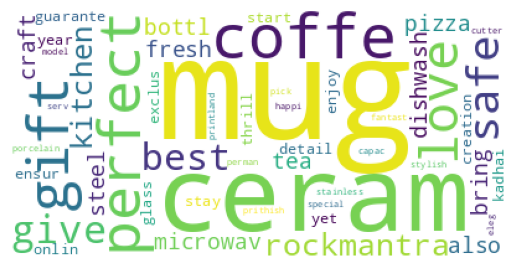

cat_watches has 49083 characters for 3023 words


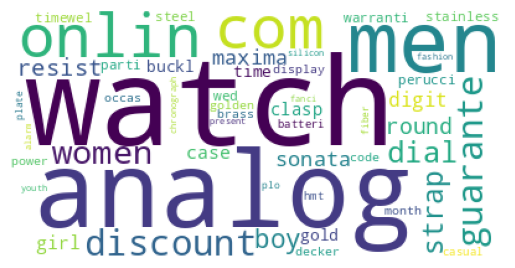

In [68]:
categories = ["cat_baby care","cat_beauty and personal care","cat_computers","cat_home decor & festive needs","cat_home furnishing","cat_kitchen & dining","cat_watches"]

tokens_per_cat={}
for idx, cat in enumerate(categories):
    df_cat = df[df[cat] == 1]
    cat_corpus = " ".join(df_cat["description"])
    
    tokens_per_cat[cat] = process_text_step_6(cat_corpus, 
                             english_stop_words, 
                             delete_words=new_delete_words, 
                             min_word_length=3,
                             use_lemm=False)
    
    print(f"{cat} has {len(cat_corpus)} characters for {len(tokens_per_cat[cat])} words")
    word_frequencies = Counter(tokens_per_cat[cat])  

    wordcloud = WordCloud(background_color="white",
                      stopwords=[],
                      max_words=50).generate_from_frequencies(frequencies=word_frequencies)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Je suis satisfait de ce nettoyage.

Pour rappel, step initial: `nb tokens 81219, nb token uniques 6284`  
maintenant: `nb tokens 39942, nb token uniques 3030`

Réduction de plus de 50%.
Je vais donc lancer cette transormation sur toutes les lignes de mon dataframe et rajouter une colonne "description_clean"

In [69]:
df["clean_desc"] = df["description"].parallel_apply(lambda x: final_process(x, 
                             english_stop_words, 
                             delete_words=new_delete_words, 
                             min_word_length=3,
                             use_lemm=False))

J'affiche la colonne description orginal et celle nettoyé pour les comparés

In [70]:
pd.set_option('display.max_colwidth', -1)  
df[["description","clean_desc"]].head(3)

/var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/ipykernel_24803/2708607600.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,description,clean_desc
0,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain curtain enhanc interior curtain polyest fabric eyelet stitch metal ring room environ curtain ant wrinkl anti shrinkag eleg give home bright appeal attent contemporari eyelet curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole draw even creat special moment given sooth print bring home eleg curtain room right amount sunlight eleg polyest multicolor abstract eyelet door curtain eleg door eyelet model name abstract polyest door curtain model multicolor length curtain polyest
1,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",sathiya cotton bath towel bath towel yellow bath towel machin washabl cotton self sathiya bath towel gsm model name sathiya cotton bath towel men women boy girl model yellow length inch inch bath towel
2,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model Name SHUVAM20PCFTSETASSORTED Ideal For Boys, Girls, Men, Women Model ID SHUVAM20PCFTSETASSORTED Size small Color Assorted Dimensions Weight 350 g Length 9 inch Width 9 inch In the Box Number of Contents in Sales Package 20 Sales Package 20 PIECE FACE TOW

In [71]:
#df[df["clean_desc"].isna()]["description"]
df[df["clean_desc"] == ""]

,uniq_id,product_name,description,cat_baby care,cat_beauty and personal care,cat_computers,cat_home decor & festive needs,cat_home furnishing,cat_kitchen & dining,cat_watches,cat,clean_desc


In [72]:
df = df.drop(df[df["clean_desc"] == ""].index)

Je sauvegarde mon dataframe dans un csv.

In [73]:
df.to_csv("./../input/df_cleaned.csv", index=False)

## Test